## Setup

In [1]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os;

os.environ["ACCELERATE_ENABLE_RICH"] = "0"

os.environ['WANDB_NOTEBOOK_NAME'] = os.path.basename(globals()['__vsc_ipynb_file__']) 

# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


import sys
from functools import partial
import json
from typing import List, Tuple, Union, Optional, Callable, Dict
import torch as t
from torch import Tensor
from sklearn.linear_model import LinearRegression
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import einops
from tqdm import tqdm
from jaxtyping import Float, Int, Bool
from pathlib import Path
import pandas as pd
import circuitsvis as cv
import webbrowser
from IPython.display import display
from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm
from eindex import eindex


from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import functools
import matplotlib.pyplot as plt

# t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "monthly_algorithmic_problems" / "september23_sum"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.september23_sum.model import create_model
from monthly_algorithmic_problems.september23_sum.training import train, TrainArgs
from monthly_algorithmic_problems.september23_sum.dataset import SumDataset,Pairs
from plotly_utils import hist, bar, imshow

# Running this on a macbook air and mps is flaky
device = t.device("cpu") #t.device("cuda" if t.cuda.is_available() else "cpu")


MAIN = __name__ == "__main__"

## Dataset

-- Note: I rewrote the Dataset class so that it balances no carry, plain carry and cascading carry  classes evenly. this puts a larger emphasis difficult cases relative to the original way this dataset was written. With random additions, cascading carry is an edge case that is quite infrequent.  

In [2]:
dataset = SumDataset(size=1000, num_digits=4).to(device)

## Transformer
-- Note: I removed weight decay

In [3]:
filename = section_dir / "sum_model_normal.pt" # note this was trained on a mac in cpu mode without cuda and mps
args = TrainArgs(
    num_digits=4,
    trainset_size=100_000,
    valset_size=5_000,
    epochs=100,
    batch_size=512,
    lr_start=2e-3,
    lr_end=1e-4,
    # weight_decay=0.001, # not weight decay, could add this back in 
    weight_decay=0.00,
    seed=42,
    d_model=48,
    d_head=24,
    n_layers=2,
    n_heads=3,
    d_mlp=None,
    normalization_type="LN",
    use_wandb=True,
    device=device,
)
model = create_model(
    num_digits=4,
    seed=0,
    d_model=48,
    d_head=24,
    n_layers=2,
    n_heads=3,
    normalization_type="LN",
    d_mlp=None,
    device=device
)
model.load_state_dict(t.load(filename))

# model = train(args)
# t.save(model.state_dict(), filename)

<All keys matched successfully>

## Cluster Code



In [108]:
from torch.utils.data import Dataset
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_samples


class ClusterState():
    def __init__(self, model, dataset, min_samples=5, min_cluster_size=5, pred_i : List[int] = [10,11,12,13]  ):
        self.model   = model
        self.dataset = dataset
        self.layers  = model.cfg.n_layers
        self.heads   = model.cfg.n_heads
        self.words   = model.cfg.n_ctx
        self.ndims   = model.cfg.d_model
        self.attn_only = model.cfg.attn_only
        self.pred_i  = pred_i
        self.min_samples      = min_samples
        self.min_cluster_size = min_cluster_size
        self.result = {}

        print(f"Dataset size={dataset.shape[0]} examples")
        print(f"Model has {self.layers} layers, {self.heads} heads, {self.words} words, {self.ndims} dimensions")

        model.reset_hooks()
        self.ctrl_logits,self.ctrl_cache  = model.run_with_cache(dataset)
        self.ctrl_preds = self.ctrl_logits.softmax(dim=-1).argmax(dim=-1)
        model.reset_hooks()


        self.filtered_words = []
        for layer in range(self.layers) :
            self.filtered_words.append( self.filter_words(layer) )
        # self.filtered_words.append( self.pred_i )

  
        for step, words in enumerate(self.filtered_words) :
            print(f"step={step} words={words}")
            all_test_data = self.generate_test_data(step)
            for data in all_test_data : 
                print(f"  activation={data[0]}")
                for lh_word in words :
                    err   = self.substitute_centoids(data[1], data[0], lh_word=lh_word, head=data[2])#, previous_steps=data[3] )
                    print( f"    word={lh_word} layer={data[1]}  head={data[2]}  err={(err.sum().item()/err.shape[0]):.0%}")

    def cluster_data(self, data, lh_word) :
        return self.cluster_values( lh_word, data=data[0], activation_name=data[1], layer=data[2], head=data[3] )

    def cluster_values(self, lh_word, data=None, activation_name=None , layer=None, head=None, selection=slice(None) ) :

        data = data[selection,lh_word,:]
        cluster_labels, silhouette_values, n_clusters, silhouette_avg  = self.find_clusters(data)
        return cluster_labels, silhouette_values, n_clusters, silhouette_avg, self.substitute_centoids(layer, activation_name, lh_word=lh_word, head=head,selection=selection)

    def generate_test_data(self, step) :
    
        prev    = lambda ans, layer : [ (an,layer)  for an in ans ]

        gen     = lambda activation_name, layer, init: [(activation_name, layer, head, init) for head in range(self.heads)]
        gen_p   = lambda activation_name, layer, init: [(activation_name+"-q", layer, head, init) for head in range(self.heads)]
        # gen_ln1 = lambda layer, init                 : [("normalized-ln1", layer, 0, init)]
        # gen_ln2 = lambda layer, init                 : [("normalized-ln2", layer, None, init)]
        gen_res = lambda activation_name, layer, init: [(activation_name, layer, None, init)]
        # gen_mlp = lambda layer, init                 : gen_res("resid_mid", layer) + gen_ln2(layer) + gen_res("mlp_out", layer) if not self.attn_only else []

        if step == 0 :
            data = gen("q",step,None) + gen("k",step,None) + gen("v",step,None)
        elif step == self.layers:

            # data =   gen_p("attn_scores",step-1,  prev( ["q","k","v"]      , step-1) ) 
            data =  gen("z",step-1,              prev( ["q","k","v"]      , step-1) )
            data +=  gen("result",step-1,        prev( ["z"], step-1)               )   
        else :
            # data =   gen_p("attn_scores",step-1,  prev( ["q","k","v"]      , step-1) ) 
            data =  gen("z",step-1,              prev( ["q","k","v"]      , step-1) )
            data +=  gen("result",step-1,         prev( ["z"], step-1)               )   

            init = prev( ["z"], step-1)
            data = data +  gen("q",step,init) + gen("k",step,init) + gen("v",step,init)
        return data


    def filter_words(self, layer, activation_name = "resid_pre") :
        filtered_words    = []
        for lh_word in range(self.words) :            
            err = self.substitute_centoids( layer, activation_name , lh_word=lh_word , mean=True) 
            if (err.sum().item() > 0 ) :
                filtered_words.append( lh_word )
        return filtered_words

    def find_clusters(self, data):
        data = data.detach().numpy()
        dbscan = HDBSCAN(min_samples=self.min_samples, min_cluster_size=self.min_cluster_size)
        cluster_labels = dbscan.fit_predict(data)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        if n_clusters > 1:
            silhouette_avg    = silhouette_score(data, cluster_labels)
            silhouette_values = silhouette_samples(data, cluster_labels)
        else:
            silhouette_avg    = 0
            silhouette_values = np.zeros(data.shape[0])

        cluster_labels = t.from_numpy(cluster_labels).to(device)

        return cluster_labels, silhouette_values, n_clusters, silhouette_avg
    
    def calc_centroid(self, data, mean=False) :
        if mean is True :
            return data.mean(0), t.zeros(data.shape[0])
        
        cluster_labels, silhouette_values, n_clusters, silhouette_avg = self.find_clusters(data)
        print( f"    n_clusters={n_clusters} silhouette_avg={silhouette_avg:.2f}")
        centroids = t.vstack([data[cluster_labels == i].mean(0) for i in cluster_labels.unique()])
        replacement_value = centroids[ cluster_labels ]
        # replacement_value[ cluster_labels < 0] = data[ cluster_labels < 0]
        return replacement_value, cluster_labels



    def replace_hook(self,replace=None) :
        _replace_hook = lambda activation,hook,replace : replace
        return functools.partial(_replace_hook, replace=replace)

    def _wh_hook(self, activation,hook,lh_word,head,an,mean):

        if (an[0] == "pattern" or an[0] ==  "attn_scores") :
            if   (an[1] == "q") :
                activation[:,head,lh_word,:], cl = self.calc_centroid(activation[:,head,lh_word,:],mean)     
            elif (an[1] == "v") :
                activation[:,head,:,lh_word], cl = self.calc_centroid(activation[:,head,:,lh_word],mean)   
        elif (lh_word is not None and head is not None) : 
            activation[:, lh_word, head, :], cl  = self.calc_centroid(activation[:, lh_word, head, :],mean) 
        elif (lh_word is not None) :
            activation[:, lh_word, :], cl        = self.calc_centroid(activation[:, lh_word, :],mean) 
        else :
            activation, cl = self.calc_centroid(activation) 

        a = an[0] if len(an) == 1 else an[0] + "-" + an[1]


        self.result[ (a , head, lh_word) ] = cl

        return activation
    
    def save_values(self,ctrl_cache, cache, lh_word,head,an,selection=slice(None)):
        if (an[0] == "pattern" or an[0] ==  "attn_scores") :
            if   (an[1] == "q") :
                ctrl_cache[selection,head,lh_word,:] =cache[selection,head,lh_word,:] 
            elif (an[1] == "v") :
                ctrl_cache[selection,head,:,lh_word] = cache[selection,head,:,lh_word] 
        elif (lh_word is not None and head is not None) : 
            ctrl_cache[ selection, lh_word, head, :]=cache[ selection, lh_word, head, :]
        elif (lh_word is not None) :
            ctrl_cache[ selection, lh_word, :]=cache[ selection, lh_word, :]  
        else :
            ctrl_cache[ selection ]=cache[ selection ]

    def wh_hook(self, lh_word = None, head = None, an=None, mean=False) :
        return functools.partial(self._wh_hook,lh_word=lh_word, head=head, an=an, mean=mean)

    def substitute_centoids(self, layer, activation_name, lh_word=None, head=None, selection=slice(None), previous_steps=None, mean=False, cluster=True, save=True) :
        self.model.reset_hooks()

        if (previous_steps is not None and len(previous_steps)!=0) :
            for step in previous_steps :      
                pn = step[0].split("-", 1)
                previous_layer = step[1]
                if (len(pn) == 2) :
                    self.model.add_hook( utils.get_act_name(pn[0], previous_layer, pn[1]), self.replace_hook( self.ctrl_cache[ pn[0], previous_layer, pn[1] ] )  )
                else :
                    self.model.add_hook( utils.get_act_name(pn[0], previous_layer       ), self.replace_hook( self.ctrl_cache[ pn[0], previous_layer       ] )  )

        an  = activation_name.split("-", 1)
        if (cluster) :
            if (len(an) == 2) :
                self.model.add_hook( utils.get_act_name(an[0], layer, an[1]), self.wh_hook( lh_word, head, an, mean)  )
            else :
                self.model.add_hook( utils.get_act_name(an[0], layer       ), self.wh_hook( lh_word, head, an, mean)  )

        logits, cache = model.run_with_cache(self.dataset[selection,:])
        self.model.reset_hooks()
        preds = logits.softmax(dim=-1).argmax(dim=-1)
        err    = t.zeros( (preds.shape[0]), dtype= t.bool)
        for outcome_word in self.pred_i :
            err =  err | self.errors( preds, outcome_word, selection)  

        if (save) :
            if (len(an) == 2) :
                self.save_values( self.ctrl_cache[ an[0], layer, an[1] ], cache[ an[0], layer, an[1] ] , lh_word, head, an, selection=~err)
            else :
                self.save_values( self.ctrl_cache[ an[0], layer], cache[ an[0], layer ] , lh_word, head, an, selection=~err)

        return err

    def errors(self, preds, outcome_word, selection=slice(None)) :
        return self.ctrl_preds[selection,outcome_word] != preds[:,outcome_word]

In [102]:
cluster_state = ClusterState(model,dataset.toks,min_samples=4,min_cluster_size=10 ) #4,10

Dataset size=1000 examples
Model has 2 layers, 3 heads, 15 words, 48 dimensions
step=0 words=[1, 2, 3, 4, 6, 7, 8, 9]
  activation=q
    n_clusters=9 silhouette_avg=1.00
    word=1 layer=0  head=0  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=2 layer=0  head=0  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=3 layer=0  head=0  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=4 layer=0  head=0  err=0%
    n_clusters=9 silhouette_avg=1.00
    word=6 layer=0  head=0  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=7 layer=0  head=0  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=8 layer=0  head=0  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=9 layer=0  head=0  err=0%
  activation=q
    n_clusters=9 silhouette_avg=1.00
    word=1 layer=0  head=1  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=2 layer=0  head=1  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=3 layer=0  head=1  err=0%
    n_clusters=10 silhouette_avg=1.00
    word=4 lay

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from itertools import chain

def generate_stats(cluster_state, layer=None, activation_name=None):

    def normalize_sizes(sizes, min_size=5, max_size=200):
        min_cluster_size = min(sizes)
        max_cluster_size = max(sizes)
        return [((size - min_cluster_size) / (max_cluster_size - min_cluster_size)) * (max_size - min_size) + min_size for size in sizes]

    clusters_with_errors = 0
    clusters_without_errors = 0
    y = []
    x = []
    sizes = []
    activation_errors    = defaultdict(list)
    activation_without_errors = defaultdict(list)
    keys = cluster_state.results.keys()


    for i, key in enumerate(keys):
        (layer_in, word, activation_name_in, head) = key
        cluster_labels, silhouette_values, n_clusters, silhouette_avg, err = cluster_state.results[key]

        if (i == 0) :
            total_err = err.double()
        else :
            total_err = total_err + err.double()

        if (layer is None or layer==layer_in) :
            for cluster in cluster_labels.unique() : 
                err_cluster = err[cluster_labels == cluster]
                sil_cluster = silhouette_values[cluster_labels == cluster]

                if (err_cluster.shape[0] > 0) :
                    if (err_cluster.sum().item() == 0):
                        activation_without_errors[activation_name_in].append( err_cluster.shape[0] )
                    else:
                        activation_errors[activation_name_in].append( err_cluster.shape[0] )

                    avg_error = err_cluster.sum().item() / err_cluster.shape[0]

                    if ( activation_name is None or activation_name==activation_name_in ) :
                        y.append(avg_error)
                        x.append(sil_cluster.sum().item() / sil_cluster.shape[0])
                        cluster_size = sil_cluster.shape[0]
                        sizes.append(cluster_size)


    clusters_with_errors = np.sum( list(chain.from_iterable(activation_errors.values())) )
    clusters_without_errors = np.sum( list(chain.from_iterable(activation_without_errors.values())) )

    total_err = total_err / len(keys)

    success_rate = clusters_without_errors / (clusters_without_errors + clusters_with_errors)

    # Scatter Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=normalize_sizes(sizes))
    plt.xlabel('Average Silhouette Score')
    plt.ylabel('Average Error')
    plt.title(f'Cluster Analysis: {success_rate:.2%} data points error free, activaiton_name={activation_name}, layer={layer}')
    plt.show()

    # Bar Chart for Activation Errors
    activation_avg_errors = {k: np.sum(v)/(np.sum(v)+ np.sum(activation_without_errors[k])) for k , v in activation_errors.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(activation_avg_errors.keys(), activation_avg_errors.values(), color='blue')
    plt.xlabel('Activation Name')
    plt.ylabel('Average Error')
    plt.title('Average Error by Activation Name')
    plt.xticks(rotation=45)
    plt.show()


    # 
    plt.hist(total_err.numpy(), bins='auto')  # 'auto' lets matplotlib choose the bin size
    plt.title('Histogram of Integer Counts')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    # Example usage:
    # generate_stats(cluster_state_instance)



In [ ]:
generate_stats(cluster_state, layer=1,activation_name="v")

In [ ]:



#   activation=v
#     word=1 layer=1  head=2 clusters=9 s_avg=1.00 err=0% unc=0%
#     word=5 layer=1  head=2 clusters=11 s_avg=0.85 err=0% unc=0% *
#     word=6 layer=1  head=2 clusters=20 s_avg=0.54 err=17% unc=4%  *
#     word=7 layer=1  head=2 clusters=21 s_avg=0.38 err=36% unc=18% *
#     word=9 layer=1  head=2 clusters=19 s_avg=0.35 err=36% unc=22% *
#     word=10 layer=1  head=2 clusters=6 s_avg=0.37 err=7% unc=2%  6%
#     word=11 layer=1  head=2 clusters=8 s_avg=0.32 err=24% unc=0% 36%
#     word=12 layer=1  head=2 clusters=3 s_avg=0.49 err=2% unc=1% *
#     word=13 layer=1  head=2 clusters=16 s_avg=0.40 err=0% unc=7% *




#   activation=v, shape=torch.Size([1000, 15, 24])
#     word=1 layer=1  head=1 clusters=9 s_avg=1.00 err=0%
#     word=5 layer=1  head=1 clusters=98 s_avg=0.39 err=0%
#     word=6 layer=1  head=1 clusters=48 s_avg=0.92 err=39%
#     word=7 layer=1  head=1 clusters=108 s_avg=0.82 err=22%
#     word=9 layer=1  head=1 clusters=92 s_avg=0.89 err=24%
#     word=10 layer=1  head=1 clusters=54 s_avg=-0.12 err=0%
#     word=11 layer=1  head=1 clusters=103 s_avg=0.32 err=38%
#     word=12 layer=1  head=1 clusters=2 s_avg=0.45 err=0%
#     word=13 layer=1  head=1 clusters=95 s_avg=0.70 err=0%


#    (layer_in, word, activation_name_in, head) = key
#     cluster_labels, silhouette_values, n_clusters, silhouette_avg, err = cluster_state.results[key]

activation_name="v"
word=9 
layer=1 
head=2 


def test(word, data, activation_name, layer, head) :
    cluster_labels, silhouette_values, n_clusters, silhouette_avg, err = cluster_state.cluster_values( word, data=data, activation_name=activation_name, layer=layer, head=head )
    errs  =  err.sum().item()/err.shape[0]
    print( f"word={word} layer={layer}  head={head} clusters={n_clusters} s_avg={silhouette_avg:.2f} err={errs:.0%}")# unc={unc:.0%}")
    total_err = err

    # max_count = 3
    # i = 0

    # while ( i < max_count and total_err.sum().item() > 2 ) :

    #     cluster_labels, silhouette_values, n_clusters, silhouette_avg, err = cluster_state.cluster_values( word, data=data, activation_name=activation_name, layer=layer, head=head, selection=total_err )
    #     errs  =  err.sum().item()/err.shape[0]
    #     print( f"word={word} layer={layer}  head={head} clusters={n_clusters} s_avg={silhouette_avg:.2f} err={errs:.0%}  err_count={err.sum().item()}")
    #     total_err[ total_err==True ] = err

    #     i=i+1

words = [1,5,6,7,9,10,11,12,13]

v = cluster_state.ctrl_cache[activation_name,layer]#[:,:,head,:]
v_out = einops.einsum(
    v, model.W_O[layer],
    "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q nheads d_model",
) 
# data = model.unembed(model.ln_final(v_out[:,:,head,:]))

for word in words :

#     # print(activation_name, v.shape)
#     # test(word, v[:,:,head,:], activation_name, layer, head)
    # print(activation_name+"_out", v_out.shape)
    test(word, v[:,:,head,:].detach(), activation_name, layer, head)
    test(word, v_out[:,:,head,:].detach(), activation_name, layer, head)

# for word in words :
#     print(activation_name+"_data", v_out.shape)
#     test(word, data.detach(), activation_name, layer, head)







In [16]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn.functional as F

def logistic_regression(X,y) :
    # Load the Iris dataset
    # iris = load_iris()
    # X = iris.data  # Features: sepal length, sepal width, petal length, petal width
    # print(X.shape)
    # y = iris.target  # Target: species of Iris (setosa, versicolor, virginica)
    # print(y.shape)
    # print(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # It's a good practice to standardize the data (mean=0 and variance=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create the logistic regression model
    log_reg = LogisticRegression(random_state=42, max_iter=1000)

    # Fit the model to the training data
    log_reg.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = log_reg.predict(X_test)

    # Output the accuracy of the model
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

    # Output the confusion matrix
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

def linear_regression(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # It's a good practice to standardize the data (mean=0 and variance=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create the linear regression model
    lin_reg = LinearRegression()

    # Fit the model to the training data
    lin_reg.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = lin_reg.predict(X_test)

    # Output the Mean Squared Error of the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.2f}')

    # Output the R-squared score of the model
    r2 = r2_score(y_test, y_pred)
    print(f'R-squared: {r2:.2f}')

    return lin_reg  # Optional: return the model for further use

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def pca_the_points(points, n_components=10, graph=True,labels=None):

    n_components=min(n_components,points.size(0))

    pca = PCA(n_components=n_components)
    data = points.detach().cpu().numpy()
    pca_result = pca.fit_transform(data)

    # Get the two components
    comp1 = pca.components_[0]
    comp2 = pca.components_[1]

    # Print the explained variance by each component
    print("Explained variance by component:", np.round(pca.explained_variance_ratio_,2)*100)

    if graph:
        # Plotting the explained variance
        plt.figure(figsize=(8, 5))
        plt.bar(range(n_components), pca.explained_variance_ratio_, align='center')
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.title("Explained Variance by Principal Component")
        plt.show()

     # Create a bar chart
        width = 0.4
        indices = np.arange(48)

        plt.figure(figsize=(12, 6))
        bar1 = plt.bar(indices, pca.components_[0], width, color='b', label='Principal Component 1')
        bar2 = plt.bar(indices + width, pca.components_[1], width, color='r', label='Principal Component 2')
        plt.xlabel("Dimensions")
        plt.ylabel("Weight")
        plt.title("Weights of Dimensions for First Two Principal Components")
        plt.xticks(indices + width / 2, indices)  # X-axis labels (centered)
        plt.legend()

        plt.tight_layout()
        plt.show()


        n=points.size(0) # n=pca_result.shape[0] number of points to plot

        xi = 1
        yi = 2


        plt.figure(figsize=(8, 8))
        plt.scatter(pca_result[:n, xi], pca_result[:n, yi], s=50, c='blue', edgecolors='k', marker='o', alpha=0.7)

        if labels is  None :
            for i in range(n) :
                plt.annotate(i, (pca_result[i, xi], pca_result[i, yi]), fontsize=18, ha="right")
        else :
            for i,label in enumerate(labels) :
                plt.annotate( label , (pca_result[i, xi], pca_result[i, yi]), fontsize=18, ha="right")

        # Setting labels and title
        plt.xlabel(f"Principal Component {xi}")
        plt.ylabel(f"Principal Component {yi}")
        # plt.xlim(-.7, .7)  # Set the x-axis limits 
        # plt.ylim(-.7, .7)  # Set the y-axis limits
        plt.title(f"Projection of Vectors on PC {xi} and PC {yi}")
        plt.grid(True)

        plt.show()

    return comp1, comp2

def show_gram_matrix(y, y_pred) :


    y_l2_normalized      = F.normalize(y, p=2, dim=0)
    y_pred_l2_normalized = F.normalize(y_pred, p=2, dim=0)

    gram_matrix = t.mm( y_l2_normalized, y_pred_l2_normalized.t())

    colorscale = [[0, 'white'], [.5, 'white'], [1.0, 'green']]

    fig = go.Figure(data=go.Heatmap(
        z=gram_matrix.detach().cpu().numpy(),
        colorscale=colorscale,
        zmin=-1,
        zmax=1,
        x=list(range(0, gram_matrix.size(-1))),  
        y=list(range(0, gram_matrix.size(-1))),
    ))

    fig.update_layout(
        title='Gram Matrix Predicted vs Actual (correlation)',
        xaxis_title='Actual Embedding position p-1',
        yaxis_title='Predicted Embedding at position p-1',
        yaxis_autorange='reversed', 
        autosize=False,
        height=500,
        width=500,
    )
    print("predicted embedding correlates highest with actual embedding")
    fig.show("png")



In [12]:
model.reset_hooks()
logits,cache  = model.run_with_cache(dataset.toks)
preds =logits.softmax(dim=-1).argmax(dim=-1)
model.reset_hooks()


In [59]:


layer = 0
digit = -2
output_digit = digit+1
print(f"Predicting digit {digit}")

remap = {}
for i in range(Pairs.p.shape[0]) :
    p = Pairs.p[i]
    remap[i] = p[3]

# for head in range(3) :

seq1 = 9
seq2 = -2
y_orig = dataset.p.detach().cpu().numpy()
yy  = np.array([ remap[y_orig[i]] for i in range(y_orig.shape[0]) ])
# yy[ yy==1] = 0
# yy[ yy==2] = 1
 
indices = np.where(yy == 1)


y  = yy

# y1 = dataset.toks.detach().cpu().numpy()[:,4] + dataset.toks.detach().cpu().numpy()[:,9]
# y = y1


y = dataset.toks.detach().cpu().numpy()[indices][:,output_digit]
X1 = cache["result",layer][:,seq1,:,:].sum(1,keepdim=False).detach().cpu().numpy()#[indices]
X2 = cache["result",layer][:,seq2,:,:].sum(1,keepdim=False).detach().cpu().numpy()#[indices]


# X1 = cache["result",layer][:,seq1,head,:].detach().cpu().numpy()#[indices]
# X2 = cache["result",layer][:,seq2,head,:].detach().cpu().numpy()#[indices]

X  = X1 #np.concatenate((X1,X2),axis=1)
print(f"head={head} using words {seq1} and {seq2},  Logistic Regression predicts the {digit} digit when there is no carrying")
# logistic_regression(X,y)

err = cluster_state.substitute_centoids(layer, "z", head=0, lh_word=seq1, selection=t.tensor(indices[0]), save=False)
print( f"err={(err.sum().item()/err.shape[0]):.0%}" ) 
    
err = cluster_state.substitute_centoids(layer, "z", head=1, lh_word=seq1, selection=t.tensor(indices[0]), save=False)
print( f"err={(err.sum().item()/err.shape[0]):.0%}" ) 

err = cluster_state.substitute_centoids(layer, "z", head=2 ,lh_word=seq1, selection=t.tensor(indices[0]), save=False)
print( f"err={(err.sum().item()/err.shape[0]):.0%}" ) 

# indices = np.where(yy == 2)
# y = dataset.toks.detach().cpu().numpy()[indices][:,output_digit]
# X1 = cache["result",layer][:,seq1,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
# X2 = cache["result",layer][:,seq2,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]

# # X1 = cache["result",layer][:,seq1,head,:].detach().cpu().numpy()[indices]
# # X2 = cache["result",layer][:,seq2,head,:].detach().cpu().numpy()[indices]

# X  = np.concatenate((X1,X2),axis=1)
# print(f"using words {seq1} and {seq2},  Logistic Regression predicts the {digit} digit when there is carrying")
# logistic_regression(X,y)

Predicting digit -2
head=2 using words 9 and -2,  Logistic Regression predicts the -2 digit when there is no carrying
    n_clusters=10 silhouette_avg=0.93
err=0%
    n_clusters=9 silhouette_avg=0.90
err=0%
    n_clusters=10 silhouette_avg=0.98
err=0%


seq=6 n_clusters=45 silhouette_avg=0.91 unclassified=0%
    n_clusters=45 silhouette_avg=0.89
err=0%
 n_clusters=614


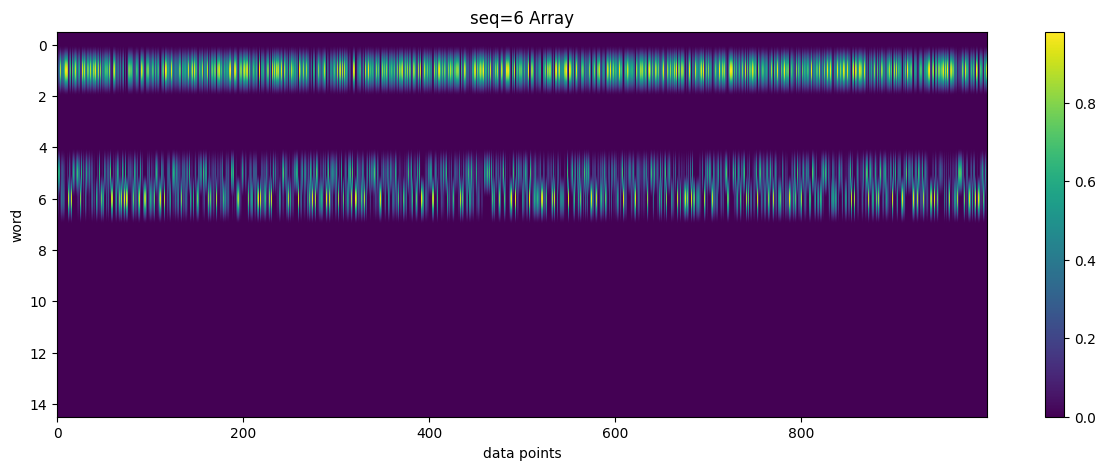

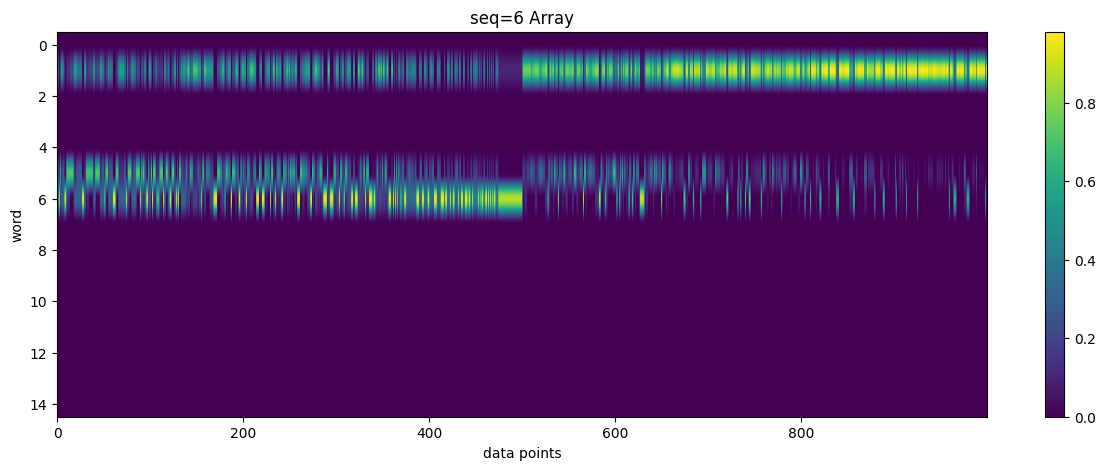

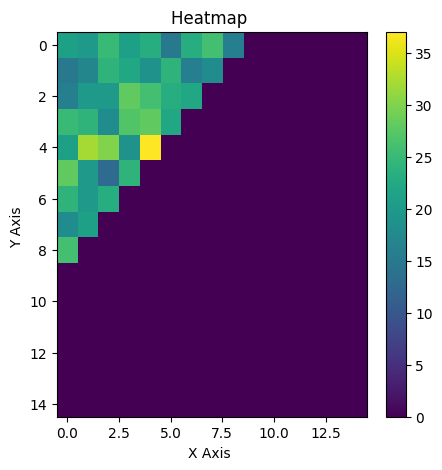

seq=7 n_clusters=51 silhouette_avg=0.64 unclassified=11%
    n_clusters=53 silhouette_avg=0.62
err=29%
 n_clusters=97


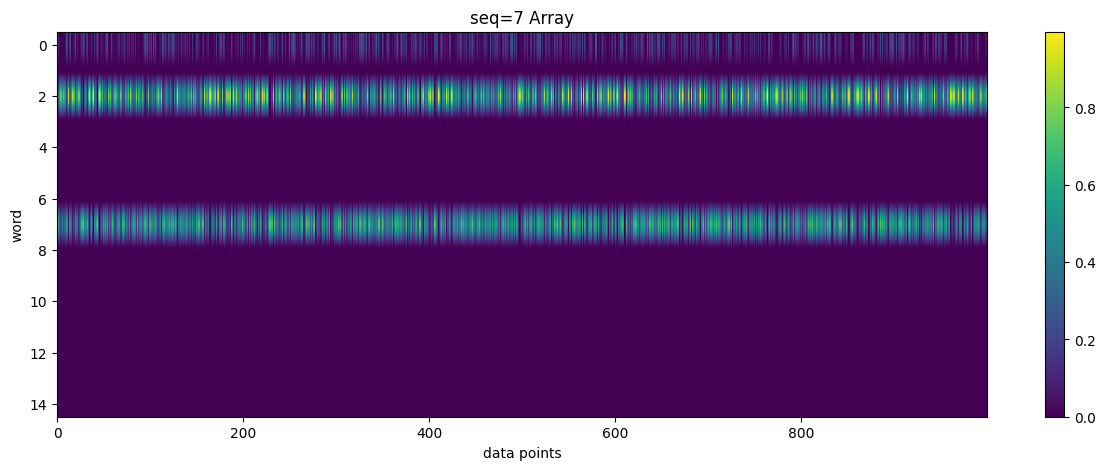

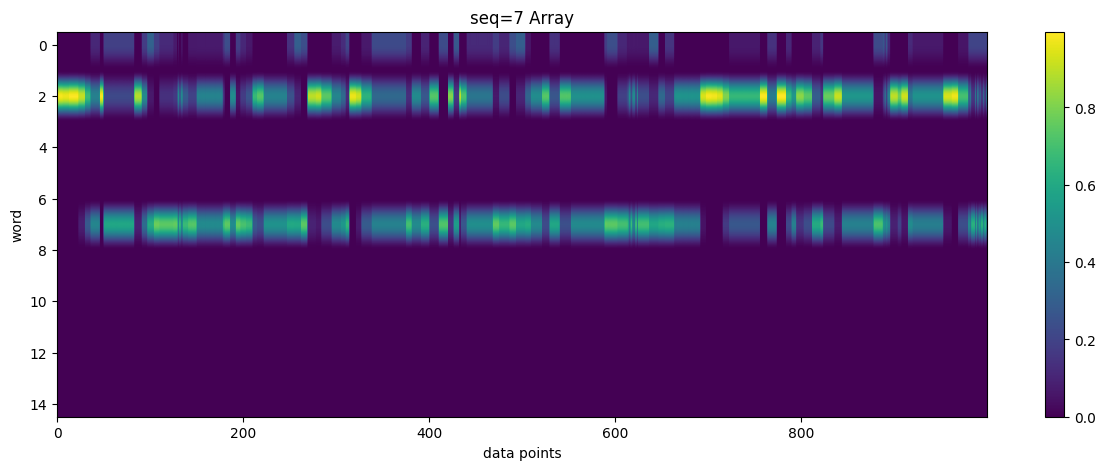

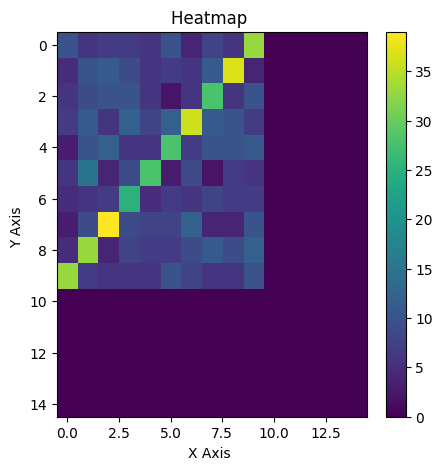

seq=8 n_clusters=37 silhouette_avg=0.46 unclassified=10%
    n_clusters=30 silhouette_avg=0.22
err=0%
 n_clusters=9


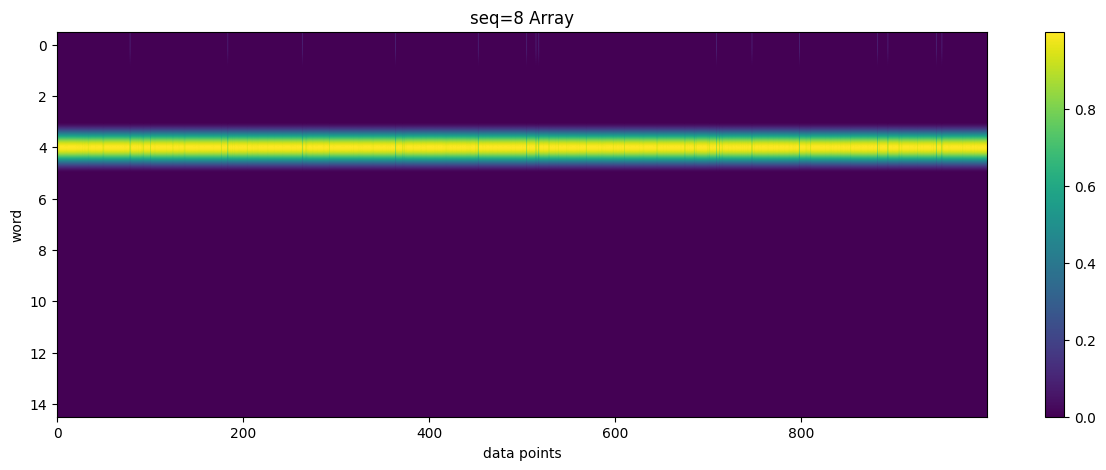

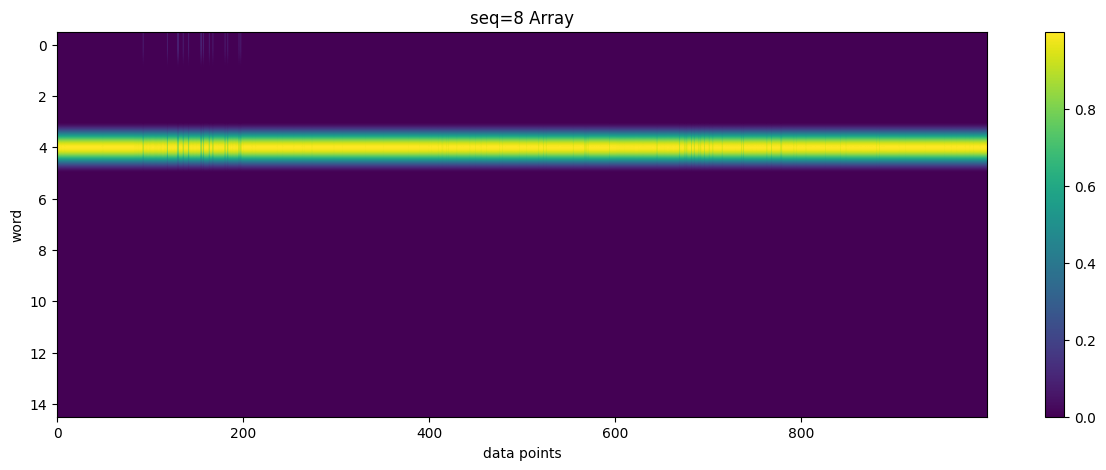

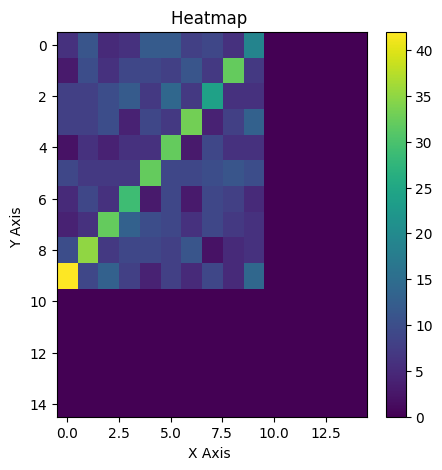

seq=9 n_clusters=46 silhouette_avg=0.71 unclassified=5%
    n_clusters=42 silhouette_avg=0.64
err=25%
 n_clusters=68


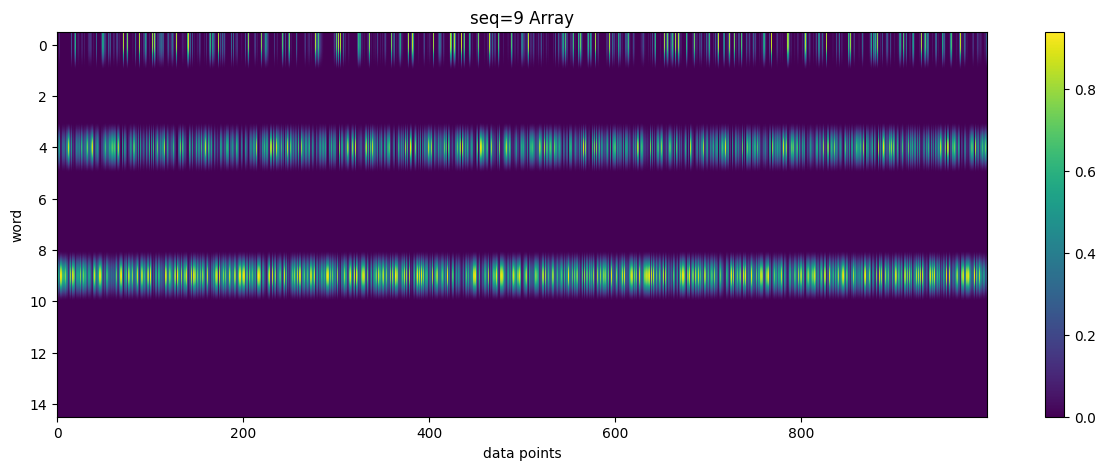

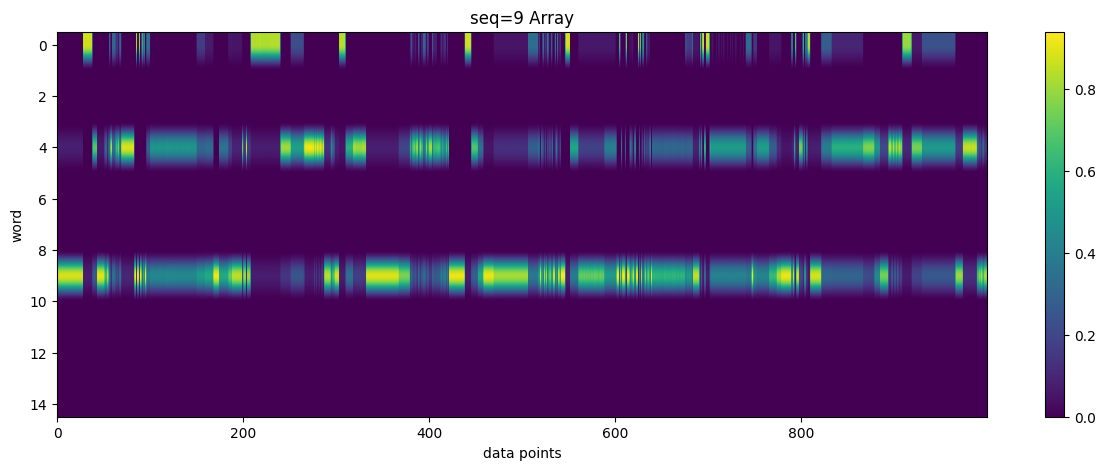

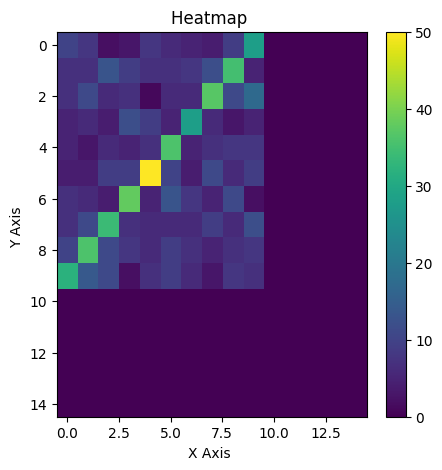

seq=10 n_clusters=49 silhouette_avg=0.68 unclassified=5%
    n_clusters=48 silhouette_avg=0.58
err=23%
 n_clusters=97


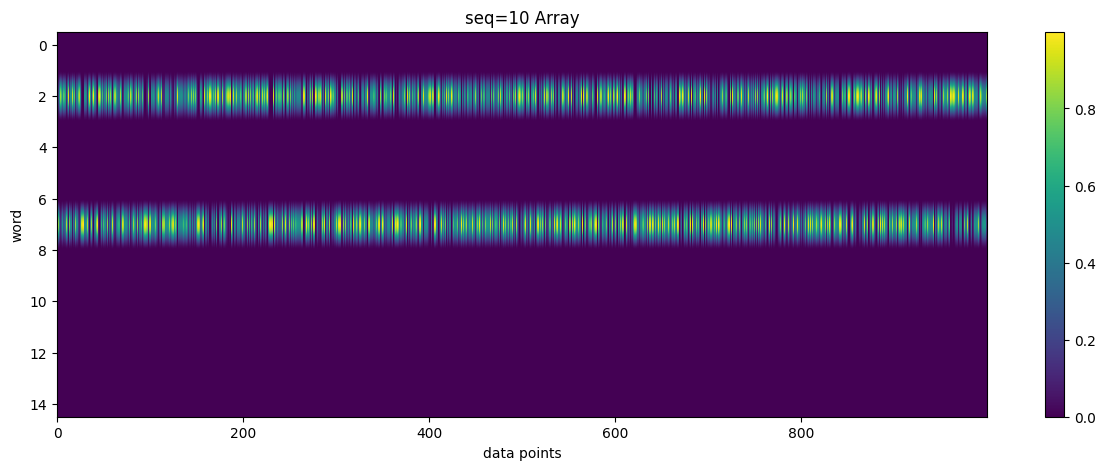

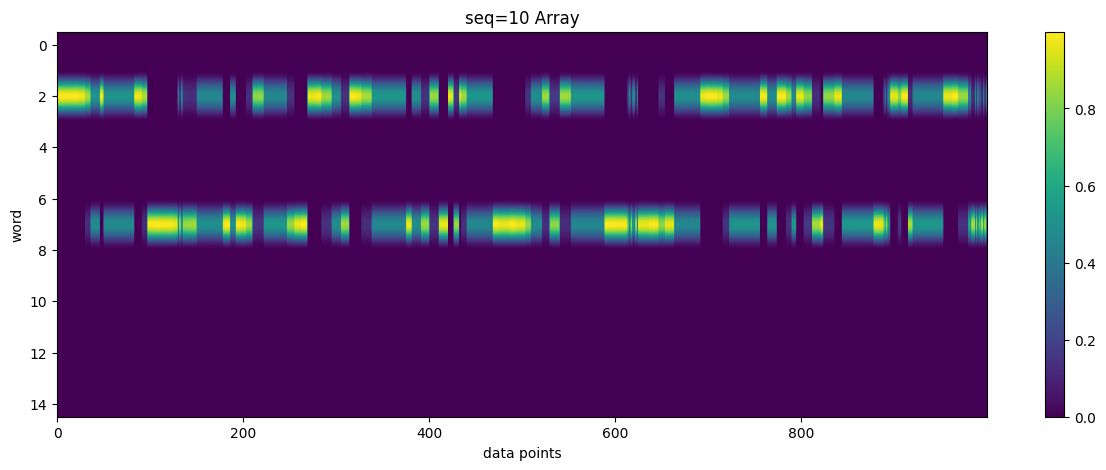

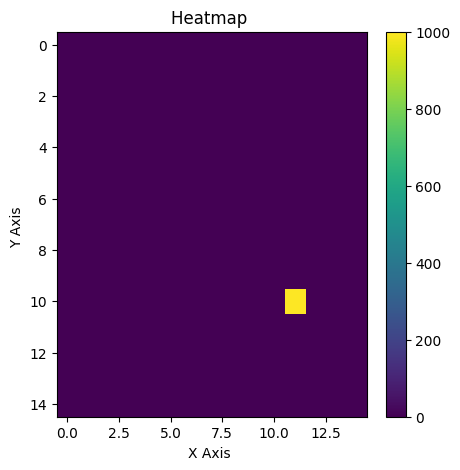

seq=11 n_clusters=43 silhouette_avg=0.47 unclassified=12%
    n_clusters=40 silhouette_avg=0.43
err=35%
 n_clusters=99


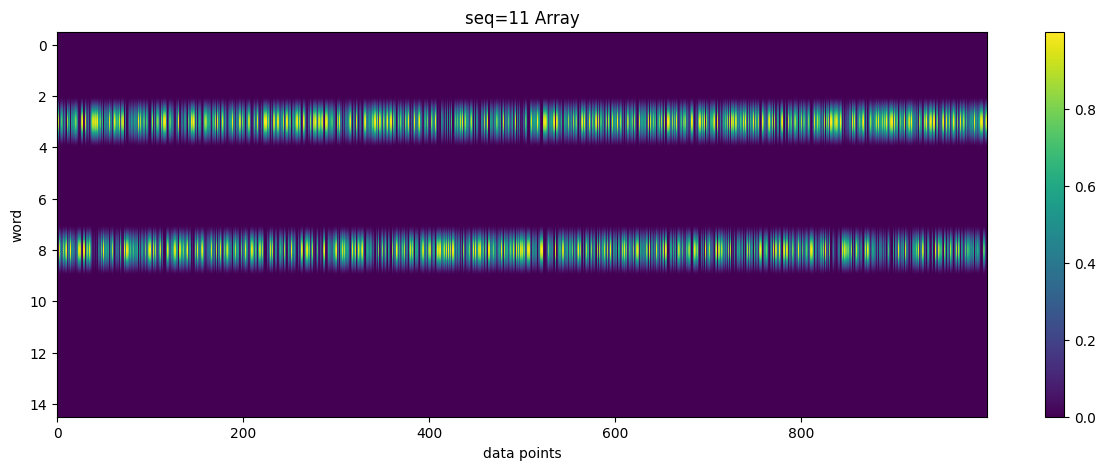

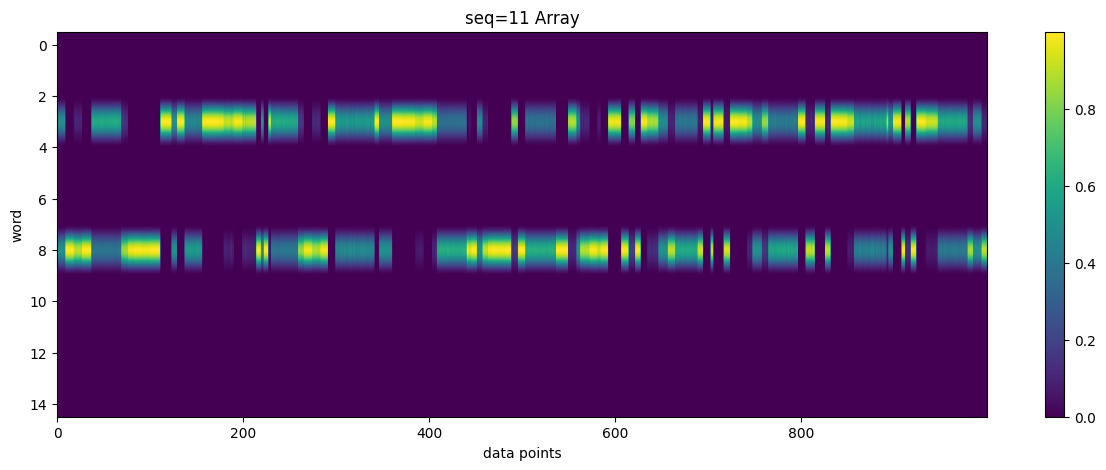

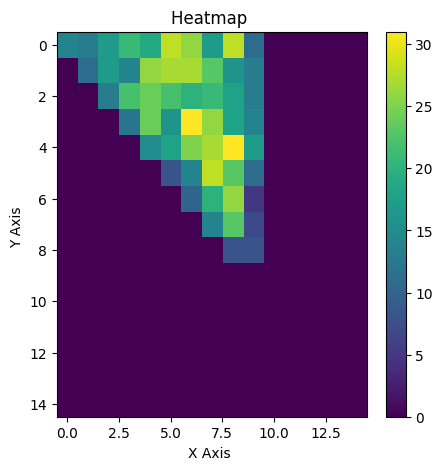

seq=12 n_clusters=49 silhouette_avg=0.54 unclassified=10%
    n_clusters=50 silhouette_avg=0.49
err=27%
 n_clusters=68


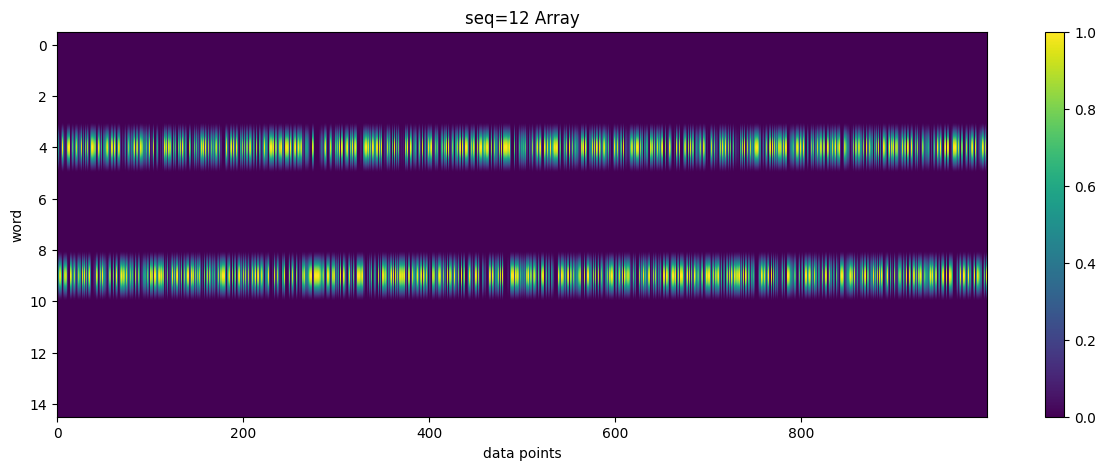

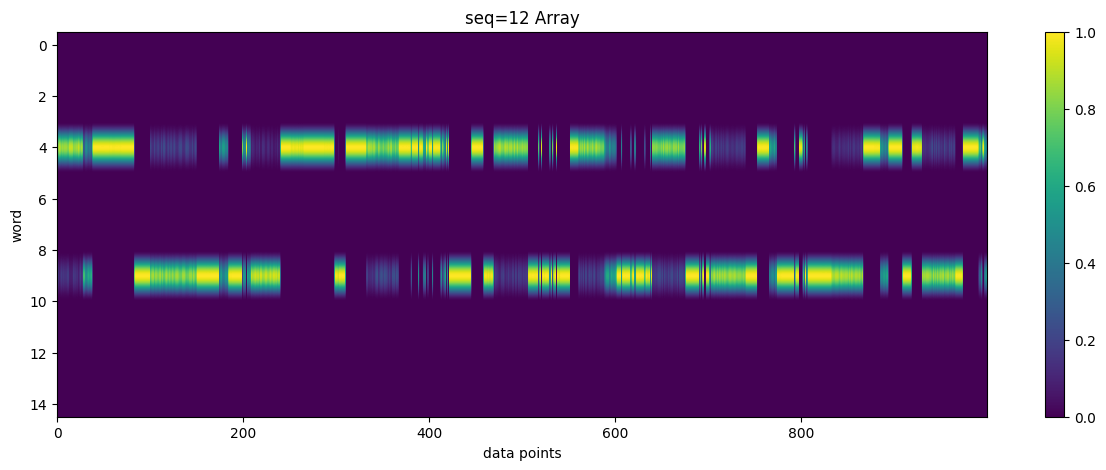

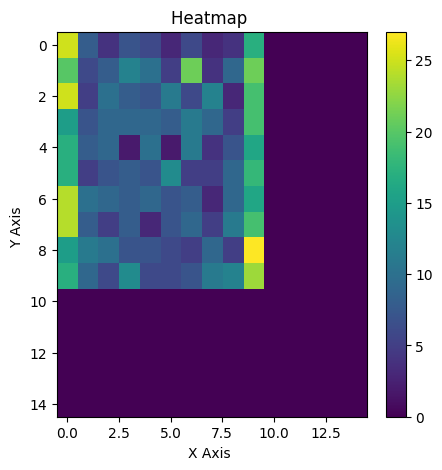

In [113]:

def combine_cluster_labels(cluster_labels_list):
    unique_rows, unique_indices = t.stack(cluster_labels_list, dim=1).unique(dim=0, return_inverse=True)
    return unique_indices

def filter_words( pattern, threshold=.05 ) :
    above_threshold = pattern.max(dim=0).values > threshold
    return t.where(above_threshold)[0].tolist()

head = 0
seq1 = 10
layer = 0
def plot_it(data) :
    data = data.detach().cpu().numpy() 
    plt.figure(figsize=(15, 5))  # Adjusting the figure size to avoid a skinny look
    plt.imshow(data.T, aspect='auto')  # 'auto' aspect ratio makes the heatmap fit the figure
    plt.colorbar()  # Adding a colorbar for reference
    plt.xlabel('data points')
    plt.ylabel('word')
    plt.title(f'seq={seq1} Array')
    plt.show()


for seq1 in range(6,13) :
# for seq1 in range(10,14) :

    pattern = cache["pattern",layer][:,head,seq1,:]

    
    cluster_labels, silhouette_values, n_clusters, silhouette_avg = cluster_state.find_clusters( pattern )
    unc = (cluster_labels < 0).sum().item() / cluster_labels.shape[0]
    print( f"seq={seq1} n_clusters={n_clusters} silhouette_avg={silhouette_avg:.2f} unclassified={unc:.0%}")
    err = cluster_state.substitute_centoids(layer, "pattern-q", head=head, lh_word=seq1, save=False)
    print( f"err={(err.sum().item()/err.shape[0]):.0%}" ) 

    words = filter_words( pattern )
    cluster_labels_list = [ cluster_state.result.get( ("v",head,word),  t.zeros(pattern.shape[0]) ) for word in words ]
    cluster_labels = combine_cluster_labels(cluster_labels_list)
    print( f" n_clusters={t.max(cluster_labels.unique()).item()}" )

    sorted_indices = t.argsort(cluster_labels)
    pattern_sorted = pattern[sorted_indices]

    plot_it(pattern)
    plot_it(pattern_sorted)

    filter = slice(None) #(cluster_labels < 0)

    # err = cluster_state.substitute_centoids(layer, "pattern-q", head=head ,lh_word=seq1, save=False)
    # print( f"err={(err.sum().item()/err.shape[0]):.0%}" ) 

    f = np.zeros((15,15))
    X  = dataset.toks[filter,seq1-5].int()
    Y  = dataset.toks[filter,seq1].int()
    # Z  = pattern[filter,0]
    # print(Z.shape)
    # f[X, Y] = Z

    np.add.at(f, (X, Y), 1)

    plt.figure(figsize=(5,5))  # Adjusting the figure size to avoid a skinny look
    plt.imshow(f, aspect='auto')  # 'auto' aspect ratio makes the heatmap fit the figure
    plt.colorbar()  # Adding a colorbar for reference
    plt.xlabel('X Axis ')
    plt.ylabel('Y Axis ')
    plt.title('Heatmap ')
    plt.show()
